In [26]:
import os
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform
from sklearn.model_selection import train_test_split
import numpy as np
from scipy.stats import randint, uniform
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

### Load metadata

In [27]:
metadata = pd.read_csv("../metadata.csv", sep=";")

### Load features and labels

In [176]:
X = pd.read_csv("./features.csv", sep=";")
y = pd.read_csv("../labels.csv", sep=";")
y = y.loc[y["Sample"].isin(X["Sample"])].set_index("Sample", drop=True)["Label"]
X = X.set_index("Sample", drop=True)
X.shape

(161, 8882)

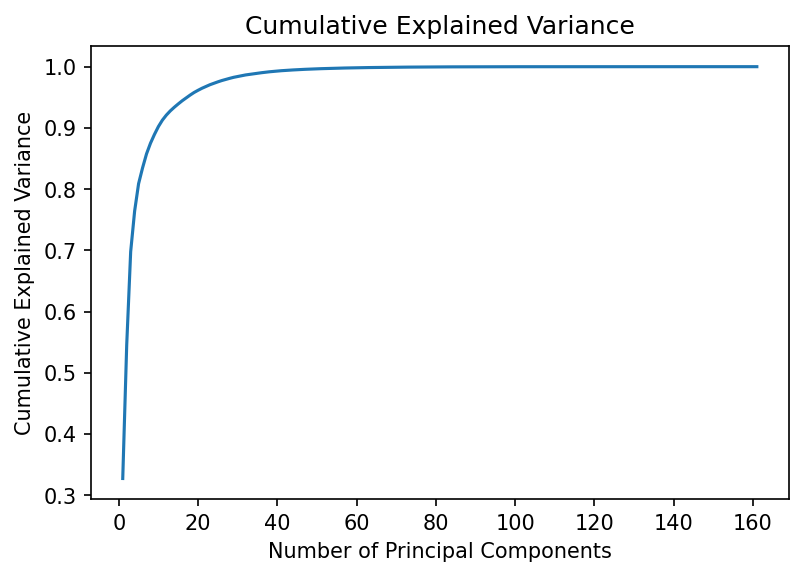

In [129]:
# Perform PCA
pca = PCA(random_state=42)
pca.fit(X)
explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)
fig = plt.figure(dpi=150)
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance)
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

### Split the data into train and test

In [130]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [131]:
pipeline = Pipeline([
    ('variance_filter', VarianceThreshold()),
    ('log_transform', FunctionTransformer(func=np.log1p, inverse_func=np.expm1)),
    ('min_max_scale', MinMaxScaler()),
    ('pca', PCA(random_state=42)),
    ('logreg', LogisticRegression(random_state=42))
])

Accuracy: 0.7272727272727273
Best score:  0.6876923076923077


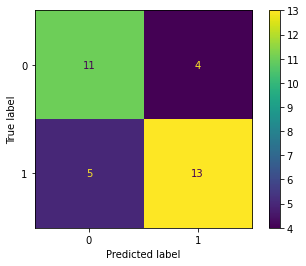

{'logreg__C': 0.2, 'pca__n_components': 10, 'variance_filter__threshold': 0.1}

In [140]:
# define the hyperparameters to search over
param_grid = {
    'variance_filter__threshold': [0.1],
    'pca__n_components': [10],
    'logreg__C': [0.2]
}

# perform grid search to find the best hyperparameters
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, n_jobs=-1)
# Fit the GridSearchCV object on the training data
grid_search.fit(X_train, y_train)
# Get the best estimator and make predictions on the testing data
best_estimator = grid_search.best_estimator_
y_pred = best_estimator.predict(X_test)

# Compute accuracy for the best found RF
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print('Best score: ', grid_search.best_score_)

cm = confusion_matrix(y_test, y_pred, labels=best_estimator.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=best_estimator.classes_)
disp.plot()
plt.show()
grid_search.best_params_